In [1]:
import os
import mlflow
import torch
import random
import numpy as np
from tqdm import tqdm
from os.path import join as pjoin
from datetime import datetime
import sys

PROJECT_PATH = 'C:\\Users\\galiger.gergo\\Desktop\\ecg-denoising\\workspace'
PROJECT_SRC_PATH = os.path.join(PROJECT_PATH, 'src\\refactored')

sys.path.append(PROJECT_SRC_PATH)

from src.trainers.FISTANetTrainer import FISTANetTrainer
from src.utils.loader import DataSplit
from src.models.FISTANetPooling import FISTANet

RANDOM_SEED = 42

mlflow.set_tracking_uri('http://localhost:8080')

In [2]:
DATA_DIR = os.path.join(PROJECT_PATH, 'data')
DATA_FILE_GEN = 'generated/BW_master_10000_2024-04-07-12-43-32.pkl'
DATA_FILE_SIGS = 'steinbrinker/testing_data_mvg_avg.npy'
DATA_FILE_BW = 'mit-bih/bw'
DATA_FILE_GAUSS = 'generated/gaussian_noise.npy'
DATA_FILE_BPDN_MAX = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-1iters_10000_2024-04-07-12-43-32.npy'
# DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-3iters_10000_2024-04-07-12-43-32.npy'
# DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-5iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_FINAL = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DICT_FILE_BW = 'steinbrinker/dictionary_BW_real_data.npy'
NOISE_TYPE = 'bw'
if NOISE_TYPE == 'bw':
    DATA_FILE_NOISE = DATA_FILE_BW
elif NOISE_TYPE == 'gauss':
    DATA_FILE_NOISE = DATA_FILE_GAUSS
DATA_SIZE = 10000
BATCH_SIZE = 1000
TVT_SPLIT = {
    'train': 80,
    'valid': 10,
    'test': 10
}

FNET_LAYER_NO = 4
FNET_FEATURE_NO = 16
LAMBDA_PRED_SP_LOSS = 0
LAMBDA_SYM_LOSS = 1e-3
LAMBDA_SP_LOSS = 1e-2
LOAD_MODEL_RUN = 'bdb03e3d83e94eccbebcaee555cb0da1'
LOAD_MODEL_EPOCH = None

LR_DEC_AFTER = 15000
LR_DEC_EVERY = 10
LEARNING_RATE = 1e-2

In [3]:
experiment = mlflow.set_experiment('pooling')

Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\galiger.gergo\.conda\envs\ECGEnvNew\Lib\threading.py", line 1073, in _bootstrap_inner
2024/07/29 20:27:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\galiger.gergo\.conda\envs\ECGEnvNew\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\galiger.gergo\.conda\envs\ECGEnvNew\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\galiger.gergo\.conda\envs\ECGEnvNew\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\galiger.gergo\.conda\envs\ECGEnvNew\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metrics
    disk_usage = psutil.disk_usage(os.sep)
                 ^^^^^^^

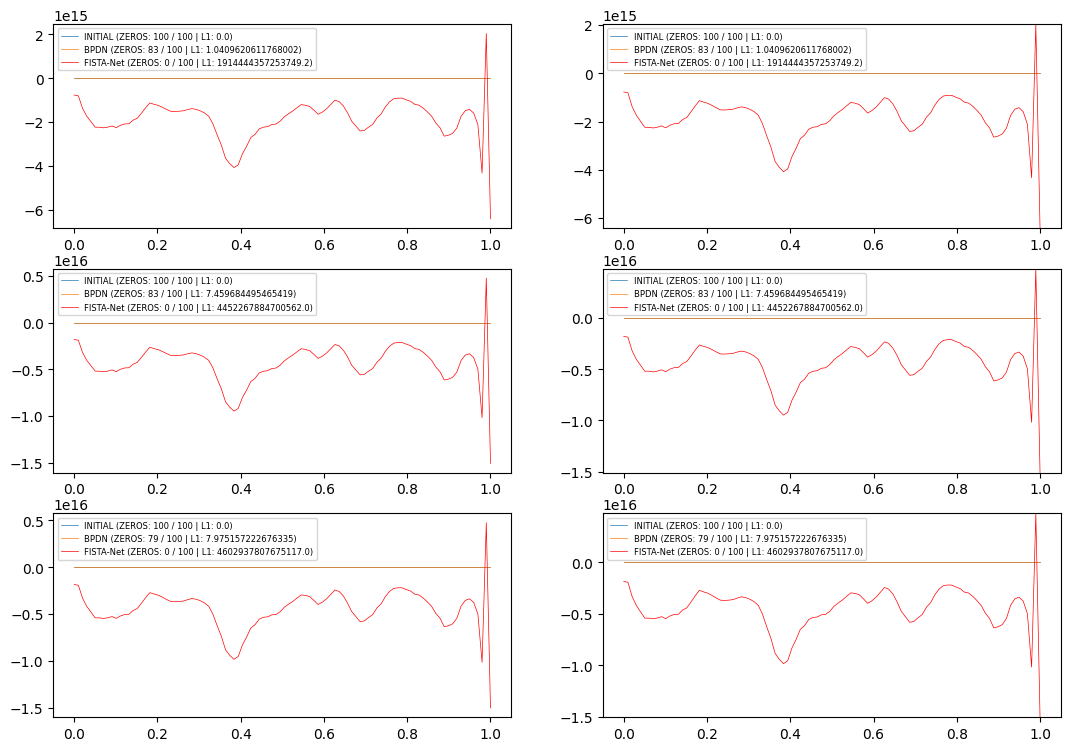

In [4]:
with mlflow.start_run(log_system_metrics=True) as run:
    # Seed random generators to ensure deterministic experiments
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    generator = torch.Generator()
    generator.manual_seed(RANDOM_SEED) 
    
    # Define PyTorch device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Read and log train, validation and test datasets
    trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE,
                                          DATA_FILE_BPDN, DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE, generator=generator)
    Psi = torch.from_numpy(np.load(pjoin(DATA_DIR, DICT_FILE_BW)))
    Psi = Psi.clone().detach().to(device=device)
    bpdn_est = np.load(os.path.join(DATA_DIR, DATA_FILE_BPDN_MAX))
    dictionary = np.load(os.path.join(DATA_DIR, DICT_FILE_BW))

    # Load model
    model = FISTANet(FNET_LAYER_NO, FNET_FEATURE_NO).to(device)
    
    # Specify and log training parameters
    dt = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    params = {
        'device': device,
        'batch_size': BATCH_SIZE,
        'lr': LEARNING_RATE,
        'lr_dec_after': LR_DEC_AFTER,
        'lr_dec_every': LR_DEC_EVERY,
        'fnet_layer_no': FNET_LAYER_NO,
        'fnet_feature_no': FNET_FEATURE_NO,
        'load_model_run': LOAD_MODEL_RUN,
        'load_model_epoch': LOAD_MODEL_EPOCH,
        'lambda_sp_loss': LAMBDA_SP_LOSS,   
        'lambda_pred_sp_loss': LAMBDA_PRED_SP_LOSS,
        'lambda_sym_loss': LAMBDA_SYM_LOSS,
    }   
    mlflow.log_params(params)

    # Define, train and evaluate model
    trainer = FISTANetTrainer(model, Psi, bpdn_est, dictionary, params)
    trainer.train(trn_ldr, val_ldr, 15000, start_epoch=0, log_model_every=100, log_comp_fig_every=10)
    trainer.evaluate(tst_ldr)
    trainer.evaluate(tst_ldr, criterion=torch.nn.HuberLoss(), crit_text='huber')